# Guided Capstone Step 4. Pre-processing and Training Data Development - Answer Key

In the previous step we used Lasso Regression to attempt to model the number of confirmed cases across all reporting countries. It was clear from those results that we needed a more specific approach so we have subset our data to include only the United States for this next step. 
We are also going to combine steps 4 and 5 of the DSM in this notebook.

**The Data Science Method**  


1.   Problem Identification 


2.   Data Wrangling 
  
 
3.   Exploratory Data Analysis   

4.   **Pre-processing and Training Data Development**  
 * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
5.   **Modeling** 
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

**<font color='DarkBlue'> Start by loading the necessary packages as we did in step 3 and printing out our current working directory just to confirm we are in the correct project directory. </font>**

In [0]:
import os
import pandas as pd
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import json
%matplotlib inline
import plotly.graph_objects as go 
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,explained_variance_score,mean_absolute_error
from math import sqrt
from sklearn.metrics import explained_variance_score
os.listdir()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['.config', 'sample_data']

**<font color='DarkBlue'> If you need to change your path refer back to the notebook on steps 1 & 2 on how to do that. Then load the csv file you created in step 3, remember it should be saved inside your data subfolder and print the first five rows.</font>**

In [0]:
file='https://raw.githubusercontent.com/AVJdataminer/COVID19_GC/master/%20data/step3_output.csv'
df=pd.read_csv(file)
df.head()

,confirmed,deaths,timestamp,province_state,long,country_region,timestamp.date,lat,recovered,date,month,day,doy,confirmed_1_day_pct_change,recovered_1_day_pct_change,deaths_1_day_pct_change,confirmed_2_day_pct_change,recovered_2_day_pct_change,deaths_2_day_pct_change,confirmed_3_day_pct_change,recovered_3_day_pct_change,deaths_3_day_pct_change,confirmed_4_day_pct_change,recovered_4_day_pct_change,deaths_4_day_pct_change,confirmed_5_day_pct_change,recovered_5_day_pct_change,deaths_5_day_pct_change,confirmed_6_day_pct_change,recovered_6_day_pct_change,deaths_6_day_pct_change,confirmed_7_day_pct_change,recovered_7_day_pct_change,deaths_7_day_pct_change,confirmed_8_day_pct_change,recovered_8_day_pct_change,deaths_8_day_pct_change,confirmed_9_day_pct_change,recovered_9_day_pct_change,deaths_9_day_pct_change,...,deaths_16_day_pct_change,confirmed_17_day_pct_change,recovered_17_day_pct_change,deaths_17_day_pct_change,confirmed_18_day_pct_change,recovered_18_day_pct_change,deaths_18_day_pct_change,confirmed_19_day_pct_change,recovered_19_day_pct_change,deaths_19_day_pct_change,confirmed_20_day_pct_change,recovered_20_day_pct_change,deaths_20_day_pct_change,confirmed_21_day_pct_change,recovered_21_day_pct_change,deaths_21_day_pct_change,confirmed_22_day_pct_change,recovered_22_day_pct_change,deaths_22_day_pct_change,confirmed_23_day_pct_change,recovered_23_day_pct_change,deaths_23_day_pct_change,confirmed_24_day_pct_change,recovered_24_day_pct_change,deaths_24_day_pct_change,confirmed_25_day_pct_change,recovered_25_day_pct_change,deaths_25_day_pct_change,confirmed_26_day_pct_change,recovered_26_day_pct_change,deaths_26_day_pct_change,confirmed_27_day_pct_change,recovered_27_day_pct_change,deaths_27_day_pct_change,confirmed_28_day_pct_change,recovered_28_day_pct_change,deaths_28_day_pct_change,confirmed_29_day_pct_change,recovered_29_day_pct_change,deaths_29_day_pct_change
0,839675.0,46583.0,1587556800,missing,-95.7129,US,2020-04-22,37902.0,77366.0,2020-04-22,4,2,113,0.019288,0.028748,0.038756,0.070569,0.069640,0.106642,0.106166,0.099933,0.145643,0.146788,0.193183,0.204816,0.200040,0.321479,0.266772,0.257373,0.414292,0.415208,0.319518,0.485066,0.644590,0.381794,0.619789,0.803306,0.446172,0.779265,0.979812,...,3.320041,1.491085,3.434090,3.842811,1.718715,4.280235,4.540978,2.046871,6.970125,5.573021,2.449023,7.595267,6.860783,2.935263,8.129809,8.792516,3.462274,10.014522,11.027627,4.189361,12.707654,14.642377,4.959961,28.030394,17.882448,5.912157,71.169776,21.992596,7.259884,88.028769,28.464263,9.015685,NaN,37.530190,11.765286,NaN,48.451168,18.150113,NaN,82.631957
1,823786.0,44845.0,1587470400,missing,-95.7129,US,2020-04-21,37902.0,75204.0,2020-04-21,4,1,112,0.050311,0.039749,0.065354,0.085234,0.069195,0.102900,0.125088,0.159840,0.159864,0.177332,0.284550,0.219509,0.233580,0.374769,0.362407,0.294549,0.443566,0.583230,0.355647,0.574524,0.736025,0.418806,0.729543,0.905946,0.483462,1.279738,1.036558,...,3.662127,1.667269,4.132678,4.334245,1.989216,6.747399,5.327783,2.383758,7.355072,6.567499,2.860797,7.874675,8.427160,3.377835,9.706720,10.578879,4.091164,12.324592,14.058764,4.847181,27.219137,17.177949,5.781360,69.152985,21.134748,7.103584,85.540852,27.364959,8.826161,NaN,36.092639,11.523731,NaN,46.606157,17.787739,NaN,79.511670,23.756161,NaN,106.541966
2,784326.0,42094.0,1587384000,missing,-95.7129,US,2020-04-20,37902.0,72329.0,2020-04-20,4,0,111,0.033251,0.028321,0.035243,0.071195,0.115500,0.088713,0.120937,0.235443,0.144699,0.174491,0.322213,0.278831,0.232539,0.388379,0.486108,0.290710,0.514331,0.629529,0.350845,0.663424,0.789026,0.412403,1.192585,0.911626,0.489992,1.313048,1.057079,...,4.007018,1.846030,6.451221,4.939608,2.221673,7.035663,6.103274,2.675862,7.535402,7.848854,3.168133,9.297409,9.868577,3.847293,11.815202,13.134990,4.567097,26.140338,16.062829,5.456527,66.471082,19.776900,6.715416,82.232451,25.624921,8.355480,NaN,33.817204,10.923835,NaN,43.685775,16.887792,NaN,74.572711,22.570321,NaN,99.944844,29.771156,NaN,136.114007
3,7590

Let's create the same plot we created in step 3 for only the US data over the same timeframe.

In [0]:
#create summarized counts for plot
ds = df.groupby(['timestamp.date']).agg({'confirmed':'sum','deaths':'sum', 'recovered':'sum'}).reset_index()

In [0]:
#create plot
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=ds['timestamp.date'],
                y=ds['confirmed'],
                name="confirmed",
                line_color='red',
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=ds['timestamp.date'],
                y=ds['deaths'],
                name="deaths",
                line_color='dimgray',
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=ds['timestamp.date'],
                y=ds['recovered'],
                name="recovered",
                line_color='green',
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(xaxis_range=['2020-01-22','2020-04-22'],
                  title_text="COVID-19 US Confirmed Cases")
fig.show()

Notice that much the early data points have very few observations. This is an important consideration in our modeling approach and indicates the potential benefit from subsetting to a later start date in our modeling process when applied to the US data only. Also, remember we created those percent changes by number of days features in the last notebook which will also be zero or nan for the earlier time period in the data. We will come back to this point later on in the notebook. For now let's subset the data to March 15, 2020 based on the plot.

Subset the data to March 15 and later.

In [0]:
#set the date col datatype to date
df['date'] = pd.to_datetime(df['date'],format = "%Y-%m-%d")
#use pd.timestamp to filter based on specified date
df = df[(df['date']>pd.Timestamp(2020,3,15))]
#review the new shape of the data. frame
df.shape

(37, 100)

## Create dummy features for categorical variables - when applicable.

**<font color='DarkBlue'> Check the values for `province_state` and determine if dummies need to be created, if so, add the dummies back to the dataframe and remove the original column for `province_state`. </font>**

In [0]:
df.province_state.value_counts()

missing    91
Name: province_state, dtype: int64

**<font color='DarkBlue'> Currently there are no states in this dataset so we skip this step. </font>** But the code is provided here for your reference.

In [0]:
#df = pd.concat([df, pd.get_dummies(df['province_state'])], axis=1).drop(['province_state'], axis =1)
#print(df.shape)
#df.head()

## Standardize the magnitude of numeric features

In the last step you may remember we applied a scaler to our data before fitting the Lasso Regression, however, we didn't save that in the output data so we will need to apply that step again before modeling the US data. Additionally, we need use the simple imputer to fill the nan or null values once again. Start by filling the null values than apply the scaler to the filled numpy array. 

**<font color='DarkBlue'> Let's start by selecting the confirmed cases as our response variable, define that in the next cell and create a y array from the response values. </font>**

In [0]:
response ='confirmed'
y = df[[response]].values

**<font color='DarkBlue'> Next, apply the simple imputer and the mean strategy to fill the missing or null values in our data frame. </font>** Exclude the response variable from this function.

In [0]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = df.drop([response], axis=1)._get_numeric_data()
imputer=imp.fit(X)
X_filled=imputer.transform(X)

**<font color='DarkBlue'> Apply the standard scaler from sklearn preprocessing. </font>**

In [0]:
scaler = preprocessing.StandardScaler().fit(X_filled)
X_scaled=scaler.transform(X_filled)

Now we are ready to split the data into trianing and testing subsets. In this project our data spans a timeframe and therefore can be considered a timeseries. The benefit from building a model to predict the number of confirmed COVID19 cases is in the ability to forecast the future number. We care less about the ability to properly estimate the current amount of COVID cases and are mor concerned with ability to forecast the potential future number of cases.  

Therefore, when it comes to splitting the data we want to train our model on data from the first part of the time series and test it on the most recent portion to confirm the model is capable of forecasting.

## Split into training and testing datasets

**<font color='DarkBlue'> Split the data into training and testing data subset based on date.</font>** Use the function provided to split the data by 80/20 for traing and testing, while keeping the dates in mind.

In [0]:
from datetime import datetime,timedelta
def dt_splitter(date_col, X, y, test_size):
        date_col = pd.to_datetime(date_col)
        xw_date=pd.DataFrame(X).merge(date_col,left_index=True, right_index=True)
        ad = (max(xw_date.date)- min(xw_date.date)).days*test_size
        split_date = min(xw_date.date) + timedelta(days=ad)
        X_train = xw_date.loc[xw_date['date'] <= split_date].drop(['date'], axis=1).values
        X_test = xw_date.loc[xw_date['date'] > split_date].drop(['date'], axis=1).values
        yw_date=pd.DataFrame(y).merge(date_col,left_index=True, right_index=True)
        y_train=yw_date.loc[yw_date['date'] <= split_date].drop(['date'], axis=1).values
        y_test=yw_date.loc[yw_date['date'] > split_date].drop(['date'], axis=1).values
        return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=dt_splitter(df['date'], X_scaled, y, .80)

# Modeling
## Fit a Lasso Regression model

Lasso regression is a type of linear regression that uses a penalty to push non-informative features coefficients to zero. It automates the feature selection process in this way. [Learn more about Lasso Regression in a short course created by Breakthrough Data Science.](https://docs.google.com/document/d/e/2PACX-1vTgO2Fykp7R1xB5VSxgCQ0R_iOi_nNEBHqGsN0VOiiGCkXNkfGqXHDpZCT0kW3wsZSJbVr0fvtuCFIz/pub)  

**<font color='DarkBlue'> Fit the Lasso Regression model as we did in the step three notebook. </font>**

In [0]:
lassoreg = Lasso(alpha=0.001,normalize=True, max_iter=1e5)
lassoreg.fit(X_train,y_train)
y_pred = lassoreg.predict(X_test)
print('Mean explained variance score for confirmed cases for the testing period = %.2f.' % explained_variance_score(y_test, y_pred))

Mean explained variance score for confirmed cases for the testing period = -3.18.


In [0]:
print('Mean absolute error for confirmed cases for the testing period = %.0f cases.' % mean_absolute_error(y_test, y_pred))

Mean absolute error for confirmed cases for the testing period = 482111 cases.


In [0]:
# Calculate mean absolute percentage error (MAPE)
y_true, y_pred = np.array(y_test), np.array(y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Lasso Regression Model Accuracy:', round(accuracy, 2), '%.')

Lasso Regression Model Accuracy: -12.1 %.


Plot the lasso forecast with the test samples.

Text(0, 0.5, 'Actual')

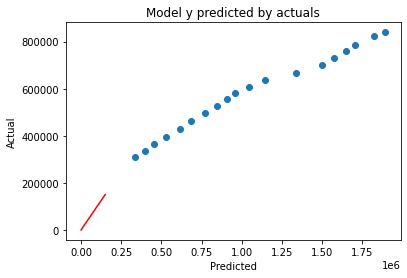

In [0]:
plt.scatter(y_pred,y_test)
plt.plot([x for x in range(0,150000)],[x for x in range(0,150000)], color='red')
plt.title("Model y predicted by actuals")
plt.xlabel("Predicted")
plt.ylabel("Actual")

Results aren't great let's try another modeling method, such as Random Forest Regression.

## Fit a Random Forest Regression model

In [0]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 500, random_state = 42)

rf.fit(X_train,y_train.ravel());

In [0]:
# Use the random forest's predict method on the test data
predictions = rf.predict(X_test)
print('Mean Absolute Error: %.0f cases.' % mean_absolute_error(y_test, predictions))

Mean Absolute Error: 408254 cases.


In [0]:
# Calculate mean absolute percentage error (MAPE)
y_true, y_pred = np.array(y_test), np.array(predictions)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('RF Accuracy:', round(accuracy, 2), '%.')

RF Accuracy: 32.34 %.


Now let's try an additional modeling method and see if we can improve our results. Given the topic at hand is a time series let's delve into ARIMA models and build one on our COVID19 data.

## What is a time series?
Time series is an ordered sequence of values of a variable at equally spaced intervals. In this project we have a timeseries made by the count of confirmed cases per day for the US. The count of recovered or deaths by day are two seperate time series. In general when working with time series data we don't incorporate additional features such as the percent change features we created in step 3. Going forward we are only considering the date and the confirmed cases, so our data is much more simplified than when building the Lasso or Random Forest Regressions. 

## Components of an ARIMA
ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is the combination of these modeling methods that make up the final ARIMA components.

### AutoRegressive (AR) --> p
A type of regression where you are trying to predict future values based on previous values of that variable. This model uses the trend of how a phenomenon changes over time at previous time stamps also referred to as lags.

We can use the PACF chart to identify the trend aka the lags that are statistically different than zero.  
### Integrated ( I ) --> d
The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.  Stationarity refers to a constant mean and standard deviation.

### Moving Average (MA) --> q
A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

These three componenets are explicitly included in the ARIMA model as parameters. 

## ARIMA (p,d q)

## Model Confirmed cases with ARIMA

Select only the confirmed cases for modeling.

In [0]:
#create timeseries data, so only date and confirmed cases data frame.
cdf = df[['date', 'confirmed']]
cdf['date'] = pd.to_datetime(cdf['date'])
cdf.set_index('date', inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Plot the confirmed cases over time and notice there is no seasonality visible.

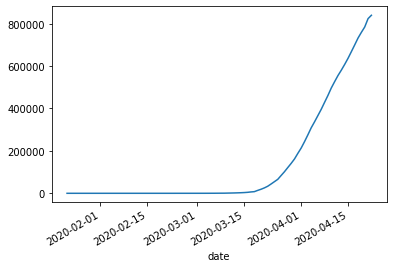

In [0]:
y = cdf['confirmed']
y.plot()

## Identify a starting value for p
We can use the partial autocorrelation plot to determine the proper number of lags to include.

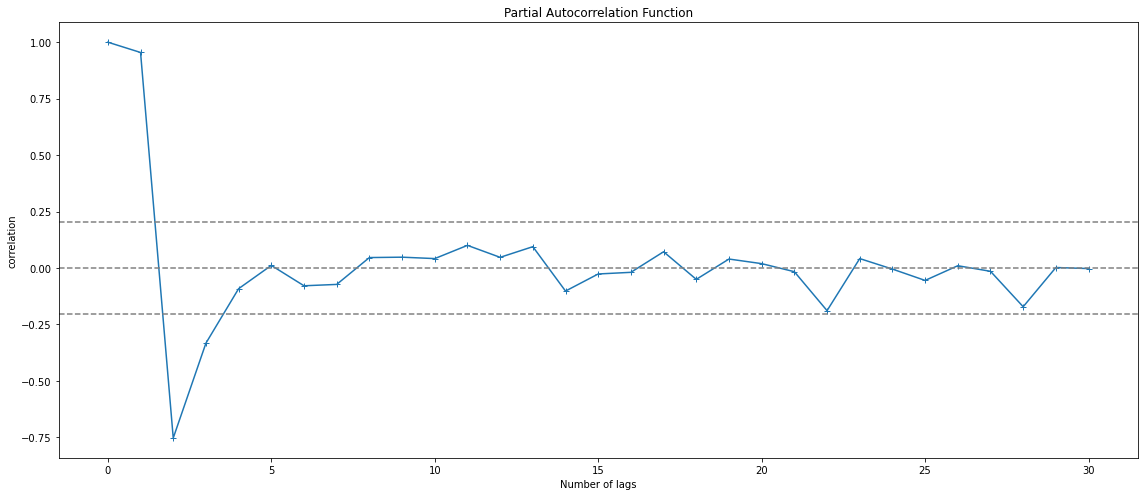

In [0]:
from statsmodels.tsa.stattools import acf, pacf
#calling partial correlation function
lag_pacf = pacf(y, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

Based on the above plot we will set p = 1. Now let's look at the autocorrelation plot.

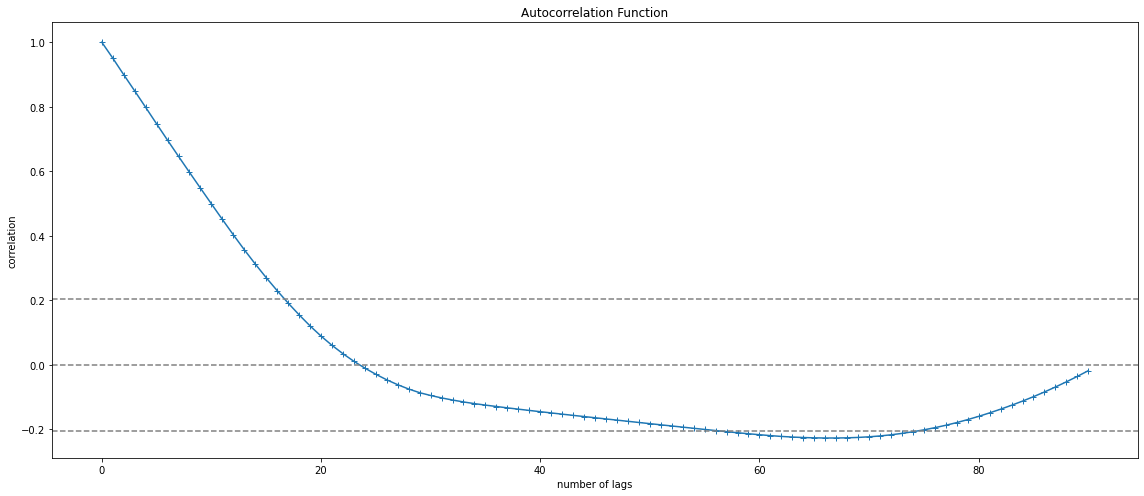

In [0]:
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings("ignore")
#calling auto correlation function
lag_acf = acf(y, nlags=300)
#Plot ACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

## Define the arima based on the diagnostic plots

In [0]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [0]:
#define the parameters and fit the model.
p=1
d=0
q=0
model = ARIMA(y, order=(p,d,q))
model_fit = model.fit()

In [0]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              confirmed   No. Observations:                   37
Model:                     ARMA(1, 0)   Log Likelihood                -431.332
Method:                       css-mle   S.D. of innovations          25300.905
Date:                Tue, 12 May 2020   AIC                            868.664
Time:                        22:22:49   BIC                            873.496
Sample:                             0   HQIC                           870.367
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -5.17e+05        nan        nan        nan         nan         nan
ar.L1.confirmed     0.9997        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0003           +0.0000j            1.0003            0.0000
-----------------------------------------------------------------------------
"""

In [0]:
forecast = model_fit.forecast()
forecast

(array([4473.52555041]),
 array([25300.90463237]),
 array([[-45115.33630531,  54062.38740613]]))

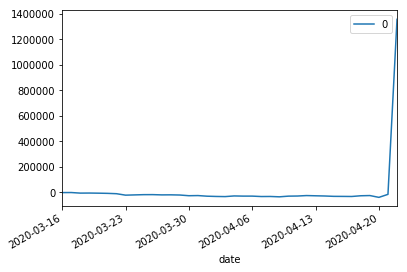

In [0]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

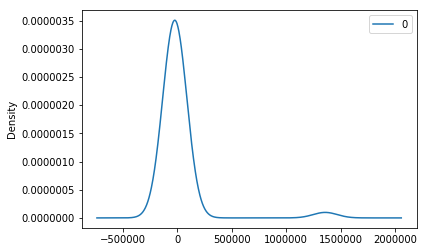

In [0]:
residuals.plot(kind='kde')

Build a second model with different parameters.

In [0]:
p=0
d=1
q=0
model = ARIMA(y, order=(p,d,q))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.confirmed   No. Observations:                   36
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -383.041
Method:                           css   S.D. of innovations          10108.069
Date:                Tue, 12 May 2020   AIC                            770.082
Time:                        22:19:52   BIC                            773.249
Sample:                             1   HQIC                           771.187
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.32e+04   1684.678    -13.769      0.000   -2.65e+04   -1.99e+04
==============================================================================
"""

Build a third model with different parameters.

In [0]:
p=1
d=2
q=1
model = ARIMA(y, order=(p,d,q))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.confirmed   No. Observations:                   35
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -347.348
Method:                       css-mle   S.D. of innovations           4902.830
Date:                Tue, 12 May 2020   AIC                            702.695
Time:                        22:10:45   BIC                            708.917
Sample:                             2   HQIC                           704.843
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                698.2132    461.039      1.514      0.140    -205.406    1601.832
ar.L1.D2.confirmed    -0.5418      0.346     -1.567      0.127      -1.219       0.136
ma.L1.D2.confirmed    -0.1603      0.308     -0.521      0.606      -0.763       0.443
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.8459           +0.0000j            1.8459            0.5000
MA.1            6.2371           +0.0000j            6.2371            0.0000
-----------------------------------------------------------------------------
"""

Train Arima model on the training dataset.

*   forecast for the time period in test data
*   compare the two for accuracy
* Then forecast for future days.
